In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

In [11]:
df = pd.read_csv('../dataset/GOOGL-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-02,1127.420044,1131.300049,1111.170044,1119.199951,1119.199951,5892100
1,2018-02-05,1100.609985,1114.989990,1056.739990,1062.390015,1062.390015,4177500
2,2018-02-06,1033.979980,1087.380005,1030.010010,1084.430054,1084.430054,3831500
3,2018-02-07,1084.969971,1086.530029,1054.619995,1055.410034,1055.410034,2597100
4,2018-02-08,1059.869995,1063.930054,1004.700012,1007.710022,1007.710022,3339600


In [12]:
minmax = MinMaxScaler().fit(df.iloc[:, 2:4].astype('float32'))
df_log = minmax.transform(df.iloc[:, 2:4].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1
0,0.426679,0.467898
1,0.368287,0.277143
2,0.269440,0.183465
3,0.266397,0.269713
4,0.185486,0.094764


In [13]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        cc=(self.Y[:,0]+self.Y[:,1])/2
        cc_logits=(self.logits[:,0]+self.logits[:,1])/2
        rr=(self.Y[:,0]-self.Y[:,1])/2
        rr_logits=(self.logits[:,0]-self.logits[:,1])/2
        self.cost=tf.reduce_mean(tf.abs(cc-cc_logits)+tf.abs(rr-rr_logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [14]:
num_layers = 1
size_layer = 10
timestamp = 5
epoch = 500
dropout_rate = 0.5
future_day = 60

In [15]:
tf.reset_default_graph()
modelnn = Model(
    0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

E:\Anacoda3 REAL\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [16]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] -1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.09605740323662758
epoch: 200 avg loss: 0.0982745049893856
epoch: 300 avg loss: 0.10219332940876484
epoch: 400 avg loss: 0.08861466594040394
epoch: 500 avg loss: 0.09203302055597305


In [17]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [18]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [19]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [20]:
df= pd.read_csv('../dataset/GOOGL-year-now.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-02,1127.420044,1131.300049,1111.170044,1119.199951,1119.199951,5892100
1,2018-02-05,1100.609985,1114.989990,1056.739990,1062.390015,1062.390015,4177500
2,2018-02-06,1033.979980,1087.380005,1030.010010,1084.430054,1084.430054,3831500
3,2018-02-07,1084.969971,1086.530029,1054.619995,1055.410034,1055.410034,2597100
4,2018-02-08,1059.869995,1063.930054,1004.700012,1007.710022,1007.710022,3339600


In [21]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

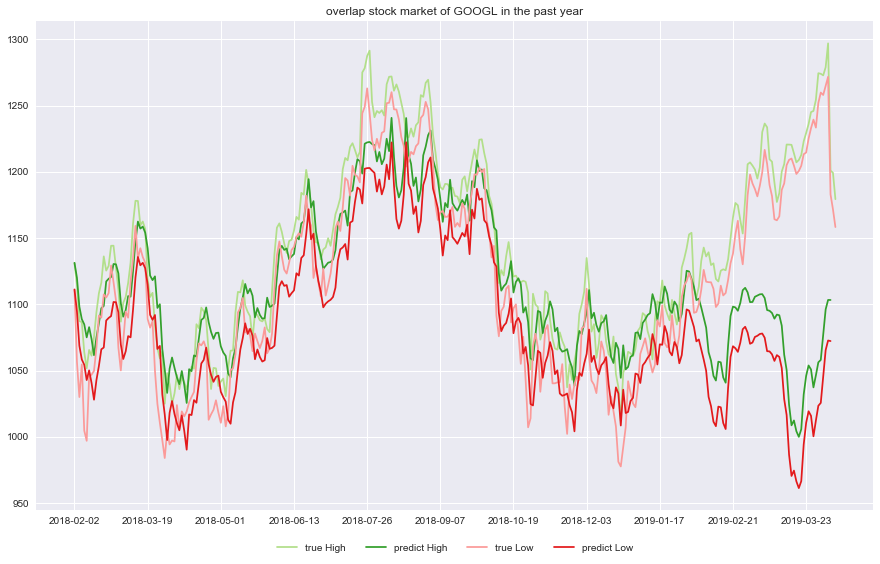

In [22]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market of GOOGL in the past year')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


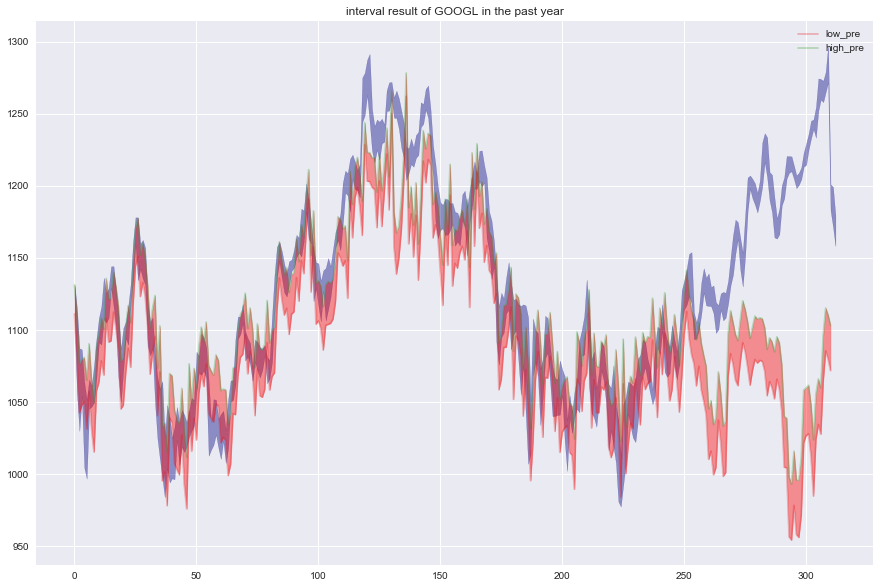

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
# ax.plot(np.array(df.iloc[:,3]).reshape(-1), c=current_palette[4], label='low_origin',alpha=0.5)
# ax.plot(np.array(df.iloc[:,2]).reshape(-1), c=current_palette[2], label='high_origin',alpha=0.5)
print(type(df))
print(type(df_log))
ax.fill_between(range(len(df.iloc[:,3])), df.iloc[:,3], df.iloc[:,2], color='navy', alpha=0.4)
ax.plot(np.array(df_log[:,1]).reshape(-1), c=current_palette[5], label='low_pre',alpha=0.3)
ax.plot(np.array(df_log[:,0]).reshape(-1), c=current_palette[3], label='high_pre',alpha=0.3)
ax.fill_between(range(len(df_log[:,0])), df_log[:,1], df_log[:,0], color='red', alpha=.4)
ax.legend()
plt.title('interval result of GOOGL in the past year')
plt.show()